Dataset: 8000 rows, 6 features
Churn rate: 0.248

Best decision threshold by F2 (validation): 0.450

=== Random Forest @ t=0.50 ===
accuracy     0.951
precision    0.935
recall       0.864
f1           0.898
f2           0.877
roc_auc      0.976
pr_auc       0.960
dtype: float64


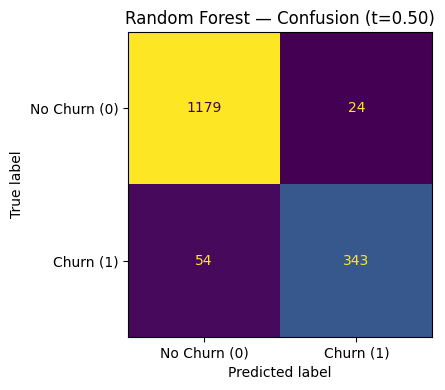


=== Random Forest @ F2-opt t=0.45 ===
accuracy     0.943
precision    0.863
recall       0.917
f1           0.889
f2           0.905
roc_auc      0.976
pr_auc       0.960
dtype: float64


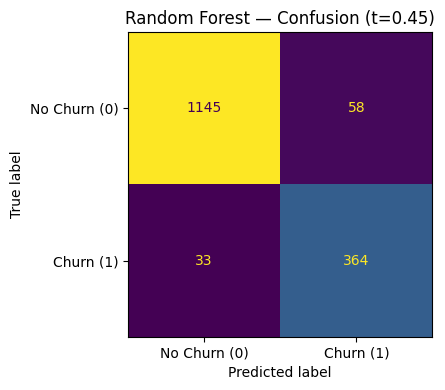

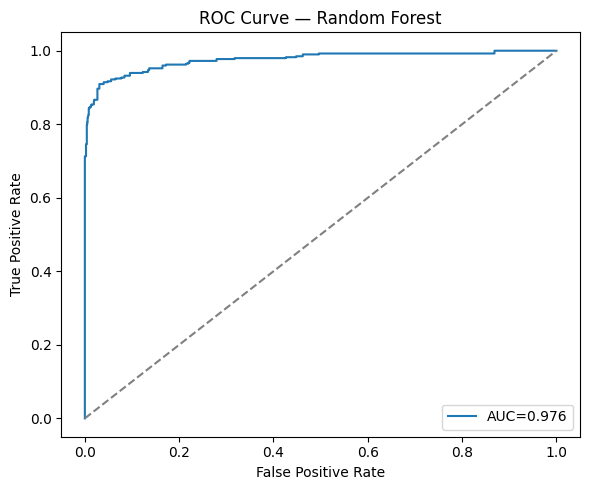

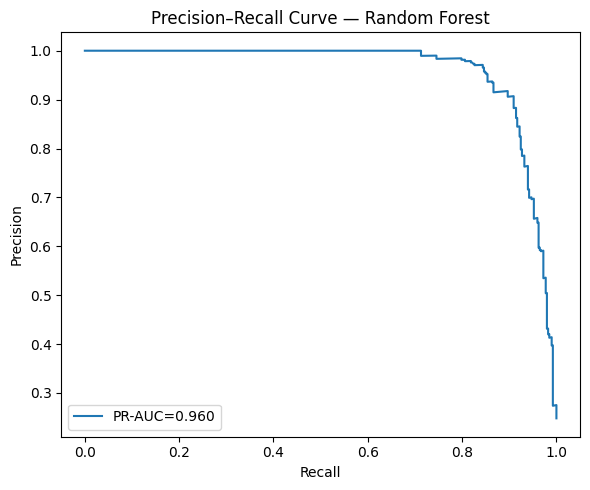


Top feature importances:
avg_spent        0.292
tenure_months    0.247
age              0.231
num_purchases    0.137
segment          0.057
gender           0.037
dtype: float64


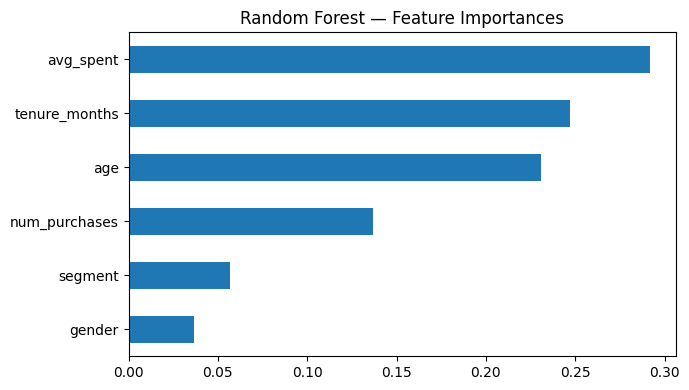


Saved:
  • Model      -> ../models\rf_churn_model.joblib
  • Threshold  -> ../models\rf_churn_threshold.json
  • Metrics    -> ../data/processed\rf_churn_metrics.json


In [1]:
# ============================================================
# PHASE 4 — Churn Prediction / Classification (Sklearn only)
# Model: Random Forest  (with F2-optimal threshold tuning)
# ============================================================

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, fbeta_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier
from joblib import dump

# -----------------------------
# Config
# -----------------------------
RANDOM_STATE = 42
TEST_SIZE    = 0.20
VAL_SIZE     = 0.20     # slice from train for threshold tuning
DATA_PATH    = "../data/processed/cleaned_transactions.csv"
MODEL_DIR    = "../models"
REPORT_DIR   = "../data/processed"
MODEL_PATH   = os.path.join(MODEL_DIR, "rf_churn_model.joblib")
THR_PATH     = os.path.join(MODEL_DIR, "rf_churn_threshold.json")
METRICS_PATH = os.path.join(REPORT_DIR, "rf_churn_metrics.json")

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(REPORT_DIR, exist_ok=True)

# -----------------------------
# 1) Load data & light prep
# -----------------------------
df = pd.read_csv(DATA_PATH)

# Encode gender (binary) and segment (label encoder)
if "gender" in df.columns:
    df["gender"] = df["gender"].map({"Male": 0, "Female": 1}).fillna(0).astype(int)

if "segment" in df.columns:
    le = LabelEncoder()
    df["segment"] = le.fit_transform(df["segment"].astype(str))

# Ensure churn is numeric 0/1
df["churn"] = df["churn"].map({0: 0, 1: 1}).astype(int)

# Light feature engineering (row-wise; no extra tables needed)
# - number of purchases per customer
# - average spend per purchase per customer
if {"customer_id", "sale_id", "total_value"}.issubset(df.columns):
    df["num_purchases"] = df.groupby("customer_id")["sale_id"].transform("count")
    df["avg_spent"]     = df.groupby("customer_id")["total_value"].transform("mean")

# Features you already used successfully
features = ["age", "gender", "segment", "tenure_months", "num_purchases", "avg_spent"]
features = [f for f in features if f in df.columns]  # guard for missing columns

# Final ML frame
data = df[features + ["churn"]].fillna(0)
X, y = data[features], data["churn"]

print(f"Dataset: {X.shape[0]} rows, {X.shape[1]} features")
print("Churn rate:", y.mean().round(3))

# -----------------------------
# 2) Train / Validation / Test
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

# Split off validation from train for threshold tuning (F2)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=VAL_SIZE, stratify=y_train, random_state=RANDOM_STATE
)

# -----------------------------
# 3) Train Random Forest
# -----------------------------
rf = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight="balanced",   # handles imbalance without SMOTE
    n_jobs=-1,
    random_state=RANDOM_STATE,
)
rf.fit(X_tr, y_tr)

# -----------------------------
# 4) Utility functions
# -----------------------------
def proba(model, X_):
    return model.predict_proba(X_)[:, 1]

def metrics_at(y_true, y_prob, thr=0.50):
    """Return all core metrics at a specific decision threshold."""
    y_pred = (y_prob >= thr).astype(int)
    return {
        "accuracy":  accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall":    recall_score(y_true, y_pred, zero_division=0),
        "f1":        f1_score(y_true, y_pred, zero_division=0),
        "f2":        fbeta_score(y_true, y_pred, beta=2, zero_division=0),
        "roc_auc":   roc_auc_score(y_true, y_prob),
        "pr_auc":    average_precision_score(y_true, y_prob),
    }, y_pred

def best_thr_by_f2(y_true, y_prob):
    """Search threshold in [0..1] that maximizes F2 on validation set."""
    ths = np.linspace(0, 1, 1001)  # 0.001 resolution
    f2s = [fbeta_score(y_true, (y_prob >= t).astype(int), beta=2, zero_division=0) for t in ths]
    return float(ths[int(np.argmax(f2s))])

def plot_confmat(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(cm, display_labels=["No Churn (0)", "Churn (1)"])
    fig, ax = plt.subplots(figsize=(5, 4))
    disp.plot(ax=ax, colorbar=False, cmap="viridis")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

# -----------------------------
# 5) Tune threshold on validation (F2)
# -----------------------------
val_prob = proba(rf, X_val)
best_thr = best_thr_by_f2(y_val, val_prob)
print(f"\nBest decision threshold by F2 (validation): {best_thr:.3f}")

# -----------------------------
# 6) Evaluate on TEST set
# -----------------------------
test_prob = proba(rf, X_test)

# A) Default threshold 0.50
m_def, y_hat_def = metrics_at(y_test, test_prob, thr=0.50)
print("\n=== Random Forest @ t=0.50 ===")
print(pd.Series(m_def).round(3))
plot_confmat(y_test, y_hat_def, "Random Forest — Confusion (t=0.50)")

# B) F2-optimal threshold from validation
m_best, y_hat_best = metrics_at(y_test, test_prob, thr=best_thr)
print(f"\n=== Random Forest @ F2-opt t={best_thr:.2f} ===")
print(pd.Series(m_best).round(3))
plot_confmat(y_test, y_hat_best, f"Random Forest — Confusion (t={best_thr:.2f})")

# -----------------------------
# 7) Curves (ROC & PR on TEST)
# -----------------------------
fpr, tpr, _ = roc_curve(y_test, test_prob)
prec, rec, _ = precision_recall_curve(y_test, test_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC={m_best['roc_auc']:.3f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Random Forest")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
plt.plot(rec, prec, label=f"PR-AUC={m_best['pr_auc']:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Random Forest")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 8) Feature Importances
# -----------------------------
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
print("\nTop feature importances:")
print(importances.round(3))

plt.figure(figsize=(7, 4))
importances.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Random Forest — Feature Importances")
plt.tight_layout()
plt.show()

# -----------------------------
# 9) Persist artifacts
# -----------------------------
# Save model
dump(rf, MODEL_PATH)

# Save chosen threshold
with open(THR_PATH, "w") as f:
    json.dump({"best_threshold_f2": best_thr}, f, indent=2)

# Save metrics (both default=0.50 and F2-opt)
all_metrics = {
    "threshold_default": 0.50,
    "metrics_default": m_def,
    "threshold_f2_opt": best_thr,
    "metrics_f2_opt": m_best,
    "features": features,
    "rows": int(X.shape[0]),
    "churn_rate": float(y.mean())
}
with open(METRICS_PATH, "w") as f:
    json.dump(all_metrics, f, indent=2)

print("\nSaved:")
print("  • Model      ->", MODEL_PATH)
print("  • Threshold  ->", THR_PATH)
print("  • Metrics    ->", METRICS_PATH)

# -----------------------------
# 10) Quick Inference example
# (Use the same feature order as training)
# -----------------------------
# sample = pd.DataFrame([{
#     "age": 41,
#     "gender": 1,
#     "segment": 2,
#     "tenure_months": 30,
#     "num_purchases": 6,
#     "avg_spent": 120_000
# }])[features]
# p = rf.predict_proba(sample)[:, 1][0]
# pred = int(p >= best_thr)
# print(f"\nExample proba={p:.3f} -> pred={pred} at thr={best_thr:.2f}")
